In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

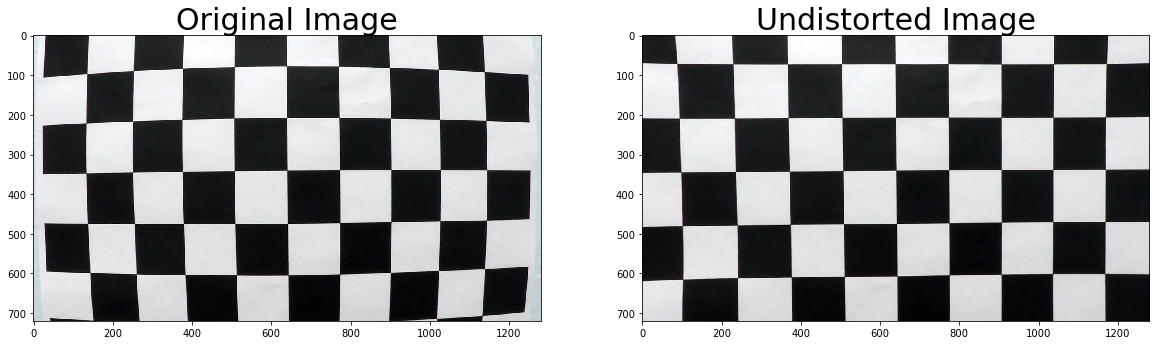

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

plt.savefig('output_images/undistorted.png', bbox_inches='tight')

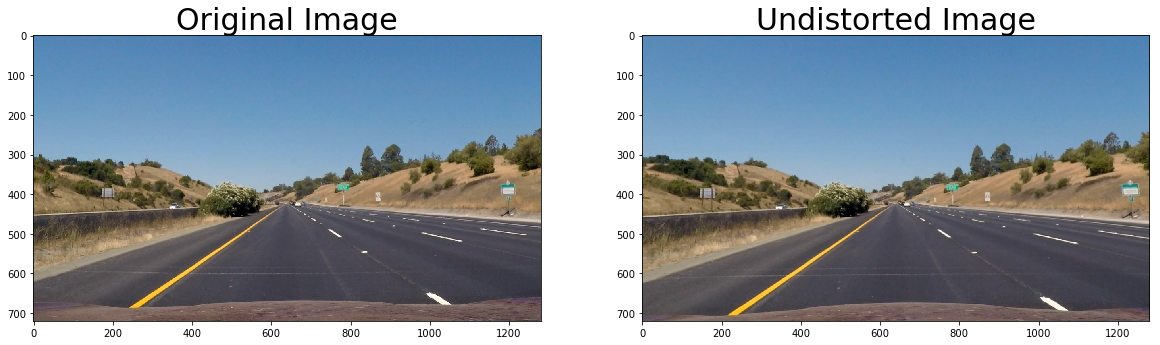

In [3]:
test_img = mpimg.imread('test_images/straight_lines1.jpg')

test_dst = cv2.undistort(test_img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_dst)
ax2.set_title('Undistorted Image', fontsize=30)

plt.savefig('output_images/test_undistorted.png', bbox_inches='tight')

In [4]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary = np.zeros_like(gray)
    binary[(gray >= thresh[0]) & (gray <= thresh[1])] = 1

    return binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(channel, thresh=(0, 255)):
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def get_binary_output(img):
    image = np.copy(img)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(190, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=3, thresh=(190, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(60, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=15)
    color_binary = color_threshold(s_channel, thresh=(170, 255))

    combined = np.zeros_like(color_binary)
    combined[((grady == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1
    
    return combined

In [5]:
img_size = test_img.shape

# These points are just determined by eyeballing the source image for the lane corners
src = np.float32([(520, 480), (760, 480), (1260, 720), (60, 720)])

dst = np.float32([
                  [0,0],
                  [1280, 0],
                  [1280, 720],
                  [0, 720],
                 ])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

for idx, pt in enumerate(src):
    print(pt, '=>', dst[idx])
    

def warper(img):
    return cv2.warpPerspective(img, M, (1280, 720))


[ 520.  480.] => [ 0.  0.]
[ 760.  480.] => [ 1280.     0.]
[ 1260.   720.] => [ 1280.   720.]
[  60.  720.] => [   0.  720.]


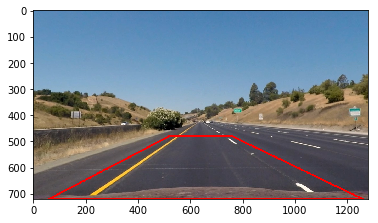

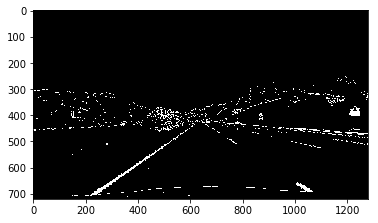

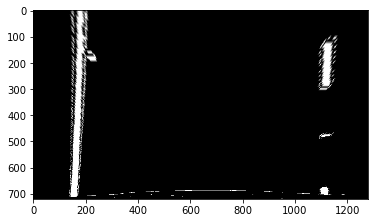

In [15]:
img = mpimg.imread('test_images/straight_lines1.jpg')
imgu = cv2.undistort(img, mtx, dist, None, mtx)

img = np.copy(imgu)
for idx, pt in enumerate(src):
    cv2.line(img, tuple(pt), tuple(src[(idx+1)%4]), (255,0,0), thickness=6)

plt.figure(0)
plt.imshow(img)

binary_output = get_binary_output(imgu)
plt.figure(1)
plt.imshow(binary_output, cmap='gray')
plt.savefig('output_images/binary_output.jpg')

perspective_img = warper(binary_output)
plt.figure(2)
plt.imshow(perspective_img, cmap='gray')

binary_warped = perspective_img
plt.savefig('output_images/binary_warped.jpg')

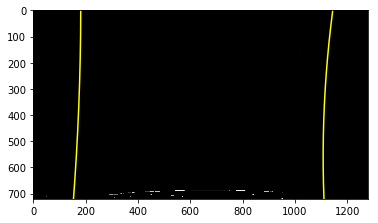

In [16]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/color_fit_lines.jpg')

In [17]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
y_eval = np.max(ploty)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

3242.25718363 m 1401.97652415 m


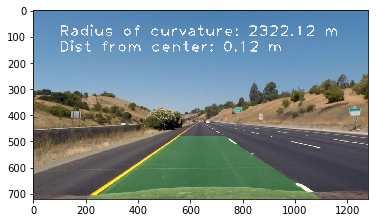

In [18]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(imgu, 1, newwarp, 0.2, 0)

lane_centre = (right_fitx[0] - left_fitx[0])/2 + left_fitx[0]
curv = "Radius of curvature: %.2f m" % np.average([left_curverad, right_curverad])
cent = "Dist from center: %.2f m" % ((lane_centre - 1280/2) * xm_per_pix)
cv2.putText(result, curv, (100, 100), 1, 4, (233,233,233), thickness=4)
cv2.putText(result, cent, (100, 160), 1, 4, (233,233,233), thickness=4)

plt.imshow(result)
plt.savefig('output_images/example_output.jpg')

In [10]:
from collections import deque
N_FITS = 10
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([], N_FITS)
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
    def smoothedx(self):
        return np.average(self.recent_xfitted, axis=0)

In [11]:
def sanity_check(x1, x2):
    mean = np.average(x2-x1)
    return np.all((x2-x1) < mean + 50)

In [12]:
import math
def process_image(img):
    global line_r, line_l
    
    imgu = cv2.undistort(img, mtx, dist, None, mtx)
    binary_output = get_binary_output(imgu)
    binary_warped = warper(binary_output)

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if line_l.detected == False or line_r.detected == False:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        line_l.detected == True
        line_r.detected == True
    else:
        left_fit = line_l.current_fit
        right_fit = line_r.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if leftx.size == 0 or rightx.size == 0:
        return img

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    line_l.current_fit = left_fit
    line_r.current_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # skip frame if left and right fits don't pass a sanity check(roughly parallel)
    if sanity_check(left_x, right_x):
        line_l.recent_xfitted.append(left_x)
        line_r.recent_xfitted.append(right_x)

    if len(line_l.recent_xfitted) == 0 or len(line_r.recent_xfitted) == 0:
        return img
        
    left_fitx = line_l.smoothedx()
    right_fitx = line_r.smoothedx()
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(imgu, 1, newwarp, 0.2, 0)
    
    lane_centre = (right_fitx[0] - left_fitx[0])/2 + left_fitx[0]
    curv = "Radius of curvature: %.2f m" % np.average([left_curverad, right_curverad])
    cent = "Dist from center: %.2f m" % ((lane_centre - 1280/2) * xm_per_pix)
    cv2.putText(result, curv, (100, 100), 1, 4, (233,233,233), thickness=4)
    cv2.putText(result, cent, (100, 160), 1, 4, (233,233,233), thickness=4)
    
    return result

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line_l = Line()
line_r = Line()

video_output = 'output_project_video.mp4'
test_vid = VideoFileClip("project_video.mp4")
op_vid = test_vid.fl_image(process_image)
%time op_vid.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [06:59<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 10min 26s, sys: 7.08 s, total: 10min 33s
Wall time: 7min 1s
